# Insider Threat Detection using Machine Learning

## Project Overview

**Objective**: Detect suspicious insider activities based on email patterns and content.

**Dataset**: CERT email dataset with attributes: id, date, user, pc, to, cc, bcc, from, size, attachments, content


## 1. Import Libraries

In [2]:
# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Set plot style
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

## 2. Load and Explore the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('dataset/cert_email_dataset.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (10000, 11)

First few rows:


,id,date,user,pc,to,cc,bcc,from,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...


In [4]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


id                0
date              0
user              0
pc                0
to                0
cc             5037
bcc            8151
from              0
size              0
attachments       0
content           0
dtype: int64

In [5]:
# Dataset statistics
print("Dataset statistics:")
df.describe(include='all')

Dataset statistics:


,id,date,user,pc,to,cc,bcc,from,size,attachments,content
count,10000,10000,10000,10000,10000,4963,1849,10000,10000.000000,10000.000000,10000
unique,10000,9090,990,990,6269,2504,483,1666,NaN,NaN,10000
top,{R3I7-S4TX96FG-8219JWFF},01/05/2010 08:34:23,KBP0008,PC-3851,Halla.Cathleen.Simmons@dtaa.com,Kirby.Bo.Pollard@dtaa.com,Winter.Veda.Burks@dtaa.com,Kirby.Bo.Pollard@dtaa.com,NaN,NaN,middle f2 systems 4 july techniques powerful d...
freq,1,4,52,52,15,29,24,48,NaN,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29929.194400,0.492800,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9935.577581,1.102937,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9038.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22843.750000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28407.500000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35306.250000,1.000000,NaN


In [6]:
# Checking unique values for categorical columns
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique PCs: {df['pc'].nunique()}")
print(f"Unique 'from' addresses: {df['from'].nunique()}")

Unique users: 990
Unique PCs: 990
Unique 'from' addresses: 1666


## 3. Data Preprocessing

In [7]:
# Convert date column to datetime
# Let pandas infer the date format
df['date'] = pd.to_datetime(df['date'])

# Extract useful time features
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 5,6 = weekend
df['is_outside_hours'] = df['hour'].apply(lambda x: 1 if x < 8 or x > 18 else 0)  # Outside 8am-6pm

# Check for missing values in 'to', 'cc', 'bcc' fields and replace with empty string
for col in ['to', 'cc', 'bcc']:
    df[col] = df[col].fillna('')

# Count recipients per email
df['to_count'] = df['to'].apply(lambda x: len(x.split(';')) if x else 0)
df['cc_count'] = df['cc'].apply(lambda x: len(x.split(';')) if x else 0)
df['bcc_count'] = df['bcc'].apply(lambda x: len(x.split(';')) if x else 0)
df['total_recipients'] = df['to_count'] + df['cc_count'] + df['bcc_count']

# Identify emails with external domains (non-company domains)
company_domains = ['dtaa.com', 'optonline.net', 'earthlink.net']

def count_external_domains(recipients, company_domains):
    if not recipients:
        return 0
    
    count = 0
    for recipient in recipients.split(';'):
        if recipient:
            is_external = True
            for domain in company_domains:
                if domain in recipient.lower():
                    is_external = False
                    break
            if is_external:
                count += 1
    return count

df['external_to'] = df['to'].apply(lambda x: count_external_domains(x, company_domains))
df['external_cc'] = df['cc'].apply(lambda x: count_external_domains(x, company_domains))
df['external_bcc'] = df['bcc'].apply(lambda x: count_external_domains(x, company_domains))
df['total_external'] = df['external_to'] + df['external_cc'] + df['external_bcc']
df['external_ratio'] = df['total_external'] / df['total_recipients'].replace(0, 1)

In [8]:
# Check if sender and receiver domains match
def extract_domain(email):
    if not email or '@' not in email:
        return None
    return email.split('@')[-1].lower()

df['from_domain'] = df['from'].apply(extract_domain)

# Extract domains from 'to' field
def get_recipient_domains(recipients):
    if not recipients:
        return []
    domains = []
    for recipient in recipients.split(';'):
        domain = extract_domain(recipient)
        if domain:
            domains.append(domain)
    return domains

df['to_domains'] = df['to'].apply(get_recipient_domains)

# Flag for domain mismatch (different sender domain from company domain)
df['domain_mismatch'] = df.apply(
    lambda row: 1 if row['from_domain'] and row['from_domain'] not in company_domains else 0, 
    axis=1
)

In [9]:
# Text preprocessing for email content
def preprocess_text(text):
    if pd.isna(text) or not text:
        return ""
    
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Apply text preprocessing to content
df['processed_content'] = df['content'].apply(preprocess_text)

In [10]:
# Content analysis features
df['content_length'] = df['content'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Check for sensitive keywords in content
sensitive_keywords = ['confidential', 'secret', 'private', 'sensitive', 'personal', 
                      'password', 'restricted', 'classified', 'proprietary', 'delete',
                      'unauthorized', 'access', 'secure', 'financial', 'salary', 'hidden',
                      'exclusive', 'undisclosed', 'destroy', 'ssn', 'social security']

def count_sensitive_words(text, keywords):
    if pd.isna(text) or not text:
        return 0
    text = text.lower()
    count = 0
    for keyword in keywords:
        count += text.count(keyword)
    return count

df['sensitive_word_count'] = df['content'].apply(lambda x: count_sensitive_words(str(x), sensitive_keywords))

In [11]:
# Calculate email size to attachment ratio to detect if attachments are removed
df['size_per_word'] = df.apply(lambda row: row['size'] / max(1, row['word_count']), axis=1)

## 4. User Behavior Analysis

In [12]:
# Create user behavior profiles
user_profile = df.groupby('user').agg({
    'id': 'count',  # Email count
    'total_recipients': 'mean',  # Average recipients per email
    'total_external': 'mean',  # Average external recipients
    'external_ratio': 'mean',  # Average ratio of external recipients
    'attachments': 'mean',  # Average attachments
    'size': 'mean',  # Average email size
    'sensitive_word_count': 'sum',  # Total sensitive words used
    'is_weekend': 'sum',  # Number of weekend emails
    'is_outside_hours': 'sum',  # Number of outside hours emails
    'content_length': 'mean',  # Average content length
    'domain_mismatch': 'sum',  # Number of domain mismatches
}).reset_index()

user_profile.rename(columns={'id': 'email_count'}, inplace=True)

# Calculate percentage of emails sent on weekends and outside hours
user_profile['weekend_ratio'] = user_profile['is_weekend'] / user_profile['email_count']
user_profile['outside_hours_ratio'] = user_profile['is_outside_hours'] / user_profile['email_count']
user_profile['domain_mismatch_ratio'] = user_profile['domain_mismatch'] / user_profile['email_count']

# Look at user behavior profiles
print("User behavior profiles:")
user_profile.head()

User behavior profiles:


,user,email_count,total_recipients,total_external,external_ratio,attachments,size,sensitive_word_count,is_weekend,is_outside_hours,content_length,domain_mismatch,weekend_ratio,outside_hours_ratio,domain_mismatch_ratio
0,AAE0190,16,2.187500,0.250000,0.114583,0.250000,30273.500000,1,0,0,334.500000,1,0.0,0.000000,0.062500
1,AAF0535,3,3.666667,1.666667,0.333333,1.333333,30503.666667,0,0,0,348.666667,1,0.0,0.000000,0.333333
2,AAF0791,9,2.555556,1.111111,0.500000,0.000000,32665.111111,4,0,0,344.444444,6,0.0,0.000000,0.666667
3,AAL0706,1,2.000000,0.000000,0.000000,0.000000,31054.000000,1,0,0,502.000000,0,0.0,0.000000,0.000000
4,AAM0658,3,2.333333,0.333333,0.111111,1.000000,34954.000000,0,0,2,271.000000,0,0.0,0.666667,0.000000


In [13]:
# Merge user profile back to main DataFrame
df = df.merge(user_profile, on='user', suffixes=('', '_avg'))

## 5. Feature Engineering - Deviation from Normal Behavior

In [14]:
# Calculate deviation from user's normal behavior
df['recipient_deviation'] = df['total_recipients'] - df['total_recipients_avg']
df['external_recipient_deviation'] = df['total_external'] - df['total_external_avg']
df['external_ratio_deviation'] = df['external_ratio'] - df['external_ratio_avg']
df['size_deviation'] = df['size'] - df['size_avg']
df['content_length_deviation'] = df['content_length'] - df['content_length_avg']

# User-PC mappings for detecting unusual PC usage
user_pcs = df.groupby('user')['pc'].apply(set).to_dict()

# Flag emails sent from unusual PCs
def is_unusual_pc(row):
    user_typical_pcs = user_pcs.get(row['user'], set())
    # If user has only one PC, it's their typical PC
    if len(user_typical_pcs) <= 1:
        return 0
    # If this PC is used less than 10% of the time by this user, flag it
    user_pc_counts = df[df['user'] == row['user']]['pc'].value_counts()
    if row['pc'] in user_pc_counts and user_pc_counts[row['pc']] / user_pc_counts.sum() < 0.1:
        return 1
    return 0

df['unusual_pc'] = df.apply(is_unusual_pc, axis=1)

In [15]:
# Generate TF-IDF features for content analysis
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_features = tfidf.fit_transform(df['processed_content'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())

# Merge TF-IDF features with main dataframe
tfidf_df = tfidf_df.reset_index().rename(columns={'index': 'tfidf_index'})
df = df.reset_index().rename(columns={'index': 'tfidf_index'})
df = pd.concat([df, tfidf_df.drop('tfidf_index', axis=1)], axis=1)

# Drop unnecessary columns for modeling
columns_to_drop = ['id', 'date', 'to', 'cc', 'bcc', 'from', 'content', 'processed_content', 
                   'from_domain', 'to_domains', 'tfidf_index']
modeling_df = df.drop(columns=columns_to_drop)

In [16]:
# Prepare final feature set
# Convert categorical variables to one-hot encoding
categorical_cols = ['user', 'pc']
modeling_df = pd.get_dummies(modeling_df, columns=categorical_cols, drop_first=True)

# Handle any remaining missing values
modeling_df = modeling_df.fillna(0)

print("Final modeling dataset shape:", modeling_df.shape)
print("\nFeatures:", modeling_df.columns.tolist()[:10], "... and more")

Final modeling dataset shape: (10000, 2118)

Features: ['size', 'attachments', 'day_of_week', 'hour', 'is_weekend', 'is_outside_hours', 'to_count', 'cc_count', 'bcc_count', 'total_recipients'] ... and more


## 6. Anomaly Detection with Unsupervised Learning

In [17]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(modeling_df)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
pca_features = pca.fit_transform(scaled_features)

print(f"Original features: {scaled_features.shape[1]}")
print(f"PCA features: {pca_features.shape[1]}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

Original features: 2118
PCA features: 982
Explained variance ratio: 0.9509


In [18]:
# Apply Isolation Forest for anomaly detection
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
isolation_forest.fit(pca_features)

# Get anomaly scores and predictions
# -1 for anomalies, 1 for normal data
anomaly_scores = isolation_forest.decision_function(pca_features)
anomaly_predictions = isolation_forest.predict(pca_features)

# Convert predictions to binary (0 for normal, 1 for anomaly)
df['anomaly_isolation_forest'] = (anomaly_predictions == -1).astype(int)
df['anomaly_score_isolation_forest'] = -anomaly_scores  # Higher score = more anomalous

In [19]:
# Apply One-Class SVM as a second anomaly detection method
one_class_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma='auto')
one_class_svm.fit(pca_features)

# Get anomaly predictions
# -1 for anomalies, 1 for normal data
anomaly_predictions_svm = one_class_svm.predict(pca_features)
anomaly_scores_svm = one_class_svm.decision_function(pca_features)

# Convert predictions to binary (0 for normal, 1 for anomaly)
df['anomaly_one_class_svm'] = (anomaly_predictions_svm == -1).astype(int)
df['anomaly_score_one_class_svm'] = -anomaly_scores_svm  # Higher score = more anomalous

In [20]:
# Combine anomaly detection results
df['combined_anomaly'] = ((df['anomaly_isolation_forest'] + df['anomaly_one_class_svm']) > 0).astype(int)
df['combined_anomaly_score'] = (df['anomaly_score_isolation_forest'] + df['anomaly_score_one_class_svm']) / 2

# Summary of detected anomalies
print(f"Isolation Forest anomalies: {df['anomaly_isolation_forest'].sum()} ({df['anomaly_isolation_forest'].mean()*100:.2f}%)")
print(f"One-Class SVM anomalies: {df['anomaly_one_class_svm'].sum()} ({df['anomaly_one_class_svm'].mean()*100:.2f}%)")
print(f"Combined anomalies: {df['combined_anomaly'].sum()} ({df['combined_anomaly'].mean()*100:.2f}%)")

Isolation Forest anomalies: 500 (5.00%)
One-Class SVM anomalies: 639 (6.39%)
Combined anomalies: 853 (8.53%)


## 7. Visualize Anomalies

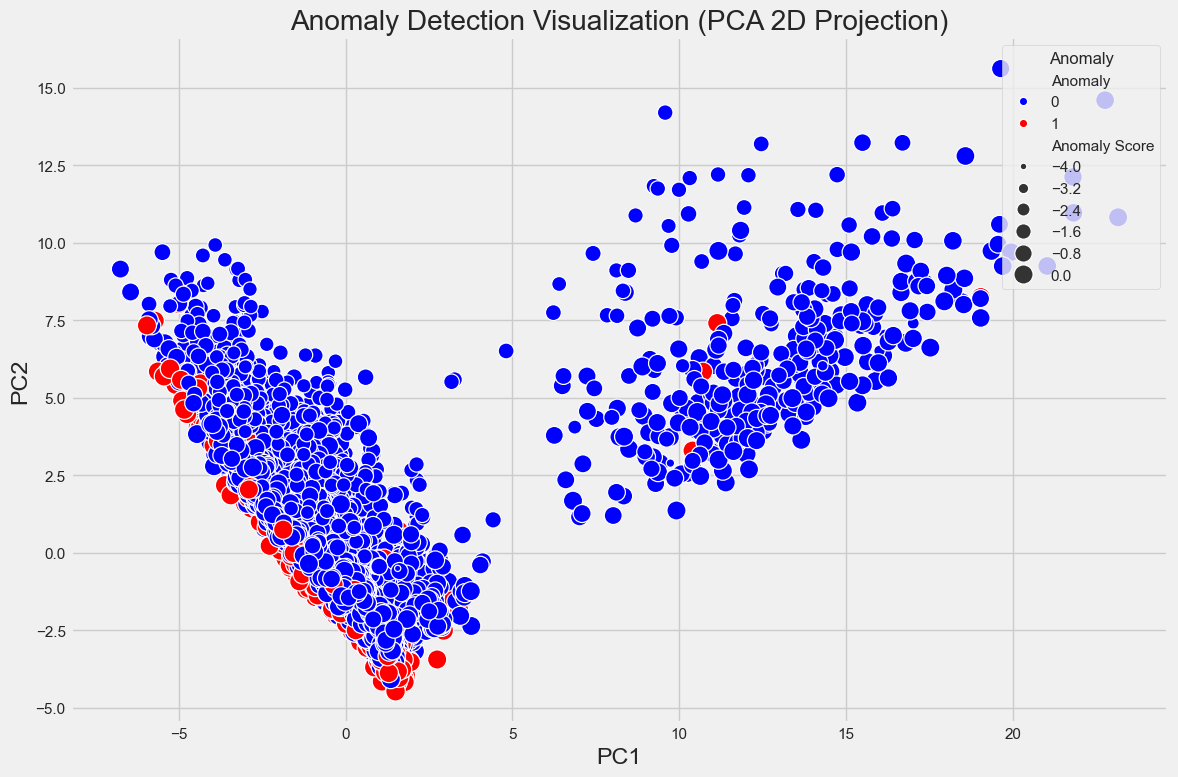

In [21]:
# Create a 2D projection for visualization using PCA
pca_2d = PCA(n_components=2)
pca_2d_features = pca_2d.fit_transform(scaled_features)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': pca_2d_features[:, 0],
    'PC2': pca_2d_features[:, 1],
    'Anomaly': df['combined_anomaly'],
    'Anomaly Score': df['combined_anomaly_score']
})

# Plot anomalies
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Anomaly', size='Anomaly Score',
                palette={0: 'blue', 1: 'red'}, sizes=(20, 200),
                data=plot_df)
plt.title('Anomaly Detection Visualization (PCA 2D Projection)')
plt.legend(title='Anomaly', loc='upper right')
plt.tight_layout()
plt.show()

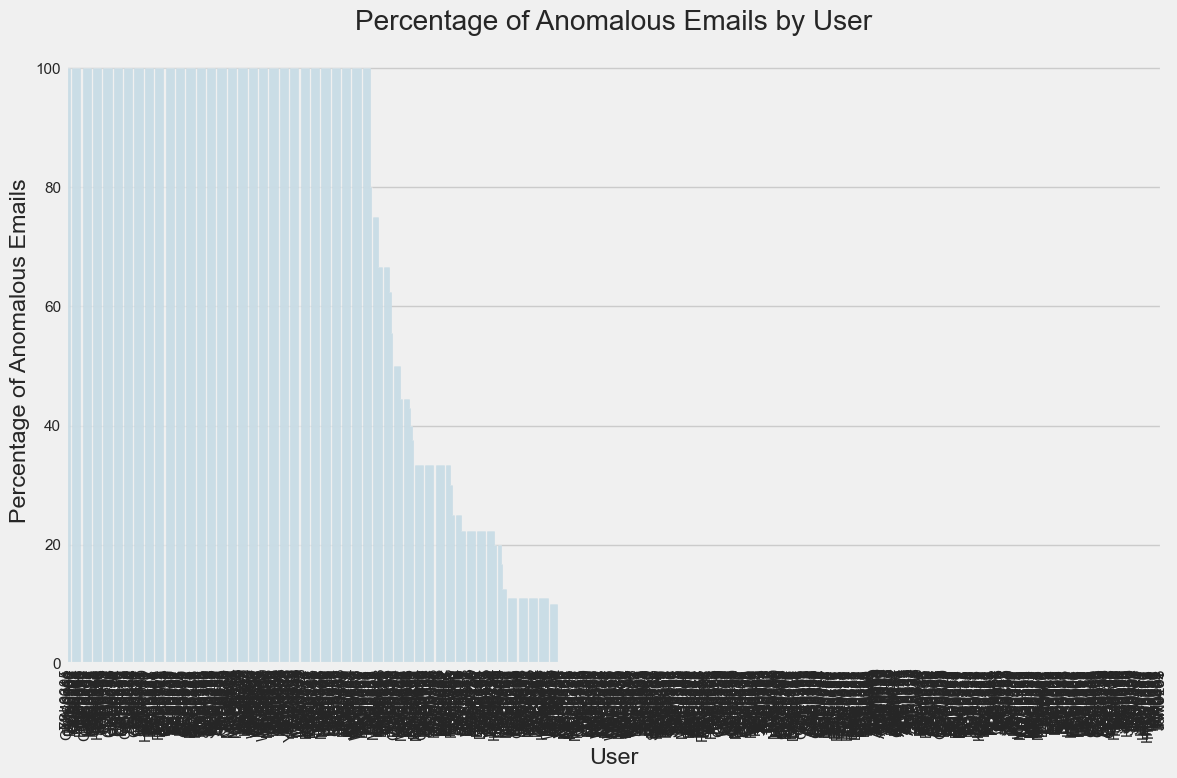

In [22]:
# Analyze anomalies by user
user_anomalies = df.groupby('user')['combined_anomaly'].agg(['sum', 'count'])
user_anomalies['percentage'] = (user_anomalies['sum'] / user_anomalies['count'] * 100).round(2)
user_anomalies = user_anomalies.sort_values('percentage', ascending=False)

# Plot user anomaly percentages
plt.figure(figsize=(12, 8))
sns.barplot(x=user_anomalies.index, y='percentage', data=user_anomalies)
plt.title('Percentage of Anomalous Emails by User')
plt.xlabel('User')
plt.ylabel('Percentage of Anomalous Emails')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [23]:
# Prepare data for supervised learning
X = modeling_df
y = df['combined_anomaly']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class imbalance
print(f"Training class distribution:\n{y_train.value_counts()}")
print(f"\nTest class distribution:\n{y_test.value_counts()}")

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")

Training class distribution:
combined_anomaly
0    6403
1     597
Name: count, dtype: int64

Test class distribution:
combined_anomaly
0    2744
1     256
Name: count, dtype: int64

After SMOTE:
combined_anomaly
1    6403
0    6403
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2744
           1       0.74      0.64      0.69       256

    accuracy                           0.95      3000
   macro avg       0.86      0.81      0.83      3000
weighted avg       0.95      0.95      0.95      3000


Confusion Matrix:


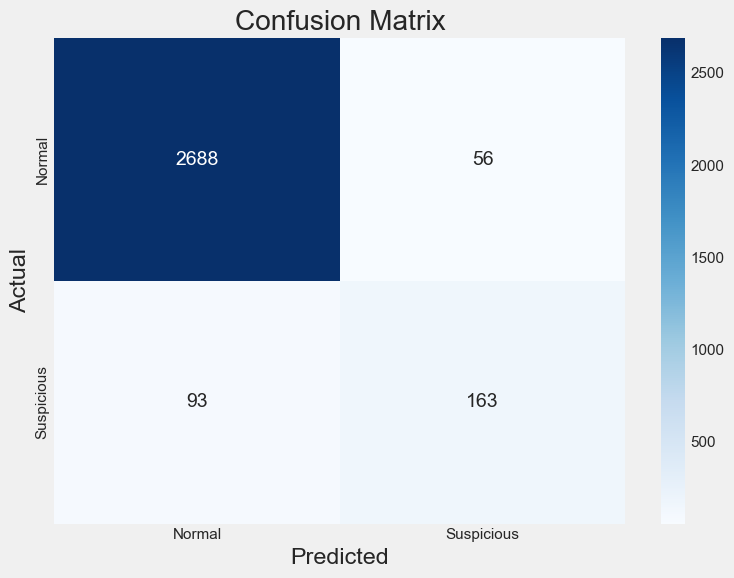

In [24]:
# Train Random Forest classifier to analyze feature importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = rf_classifier.predict(X_test)

# Model evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspicious'],
            yticklabels=['Normal', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

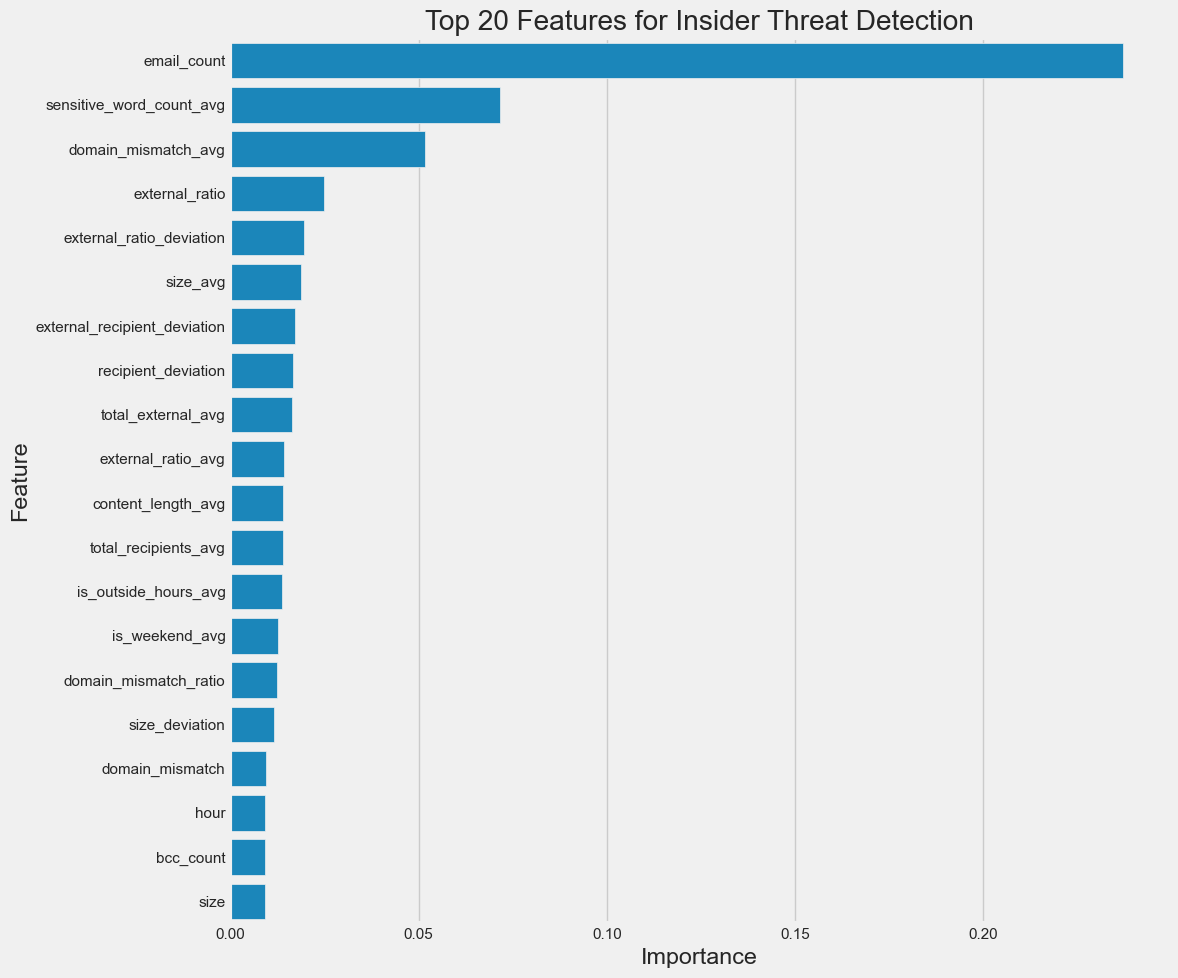

Top 10 important features:
                        Feature  Importance
0                   email_count    0.237147
1      sensitive_word_count_avg    0.071577
2           domain_mismatch_avg    0.051751
3                external_ratio    0.024901
4      external_ratio_deviation    0.019569
5                      size_avg    0.018800
6  external_recipient_deviation    0.017192
7           recipient_deviation    0.016698
8            total_external_avg    0.016228
9            external_ratio_avg    0.014175


In [25]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

# Plot feature importance
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Features for Insider Threat Detection')
plt.tight_layout()
plt.show()

print("Top 10 important features:")
print(feature_importance.head(10))

## 9. Hyperparameter Tuning

In [26]:
# Hyperparameter tuning with Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Use a smaller subset of features for faster tuning
top_feature_names = feature_importance.head(20)['Feature'].tolist()
X_train_top = X_train_resampled[top_feature_names]
X_test_top = X_test[top_feature_names]

# Grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train_top, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

Best parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score: 0.9712


Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2744
           1       0.71      0.64      0.67       256

    accuracy                           0.95      3000
   macro avg       0.84      0.81      0.82      3000
weighted avg       0.95      0.95      0.95      3000



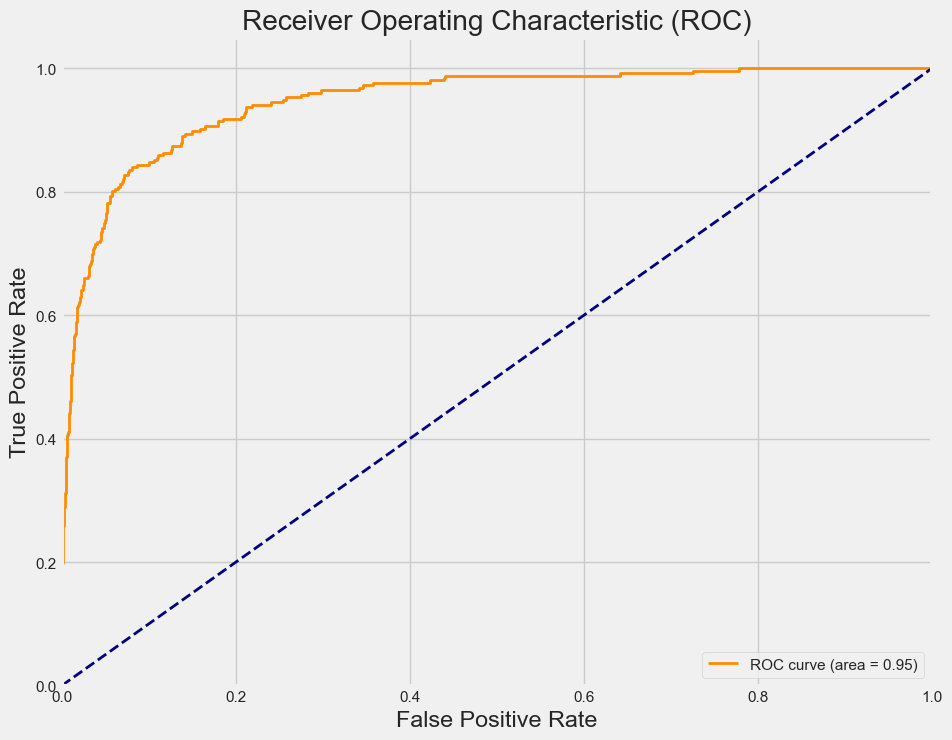

In [27]:
# Train final model with best parameters
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_best = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print("Final Model Classification Report:")
print(classification_report(y_test, y_pred_best))

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 10. User Risk Scoring and Anomaly Explanation

In [28]:
# Apply trained model to predict on all data
final_predictions = best_rf.predict(X)
final_probabilities = best_rf.predict_proba(X)[:, 1]

# Add predictions and risk scores to the original dataframe
df['ml_prediction'] = final_predictions
df['risk_score'] = final_probabilities

# Calculate user risk scores
user_risk = df.groupby('user')['risk_score'].agg(['mean', 'max', 'count'])
user_risk['suspicious_emails'] = df[df['ml_prediction'] == 1].groupby('user')['id'].count()
user_risk['suspicious_emails'] = user_risk['suspicious_emails'].fillna(0).astype(int)
user_risk['suspicious_percentage'] = (user_risk['suspicious_emails'] / user_risk['count'] * 100).round(2)
user_risk = user_risk.sort_values('mean', ascending=False)

print("User Risk Scoring:")
print(user_risk)

User Risk Scoring:
             mean       max  count  suspicious_emails  suspicious_percentage
user                                                                        
SAH0599  0.973066  0.973066      1                  1                  100.0
JKM0303  0.971088  0.971088      1                  1                  100.0
FWM0707  0.970918  0.970918      1                  1                  100.0
IJM0139  0.970905  0.970905      1                  1                  100.0
EGD0132  0.970497  0.970497      1                  1                  100.0
...           ...       ...    ...                ...                    ...
IRM0931  0.030481  0.064596     34                  0                    0.0
DLM0051  0.029227  0.066723     36                  0                    0.0
CMB0912  0.028486  0.061076     31                  0                    0.0
AJR0319  0.028194  0.064336     45                  0                    0.0
YIC0195  0.026888  0.048533     37                  0    

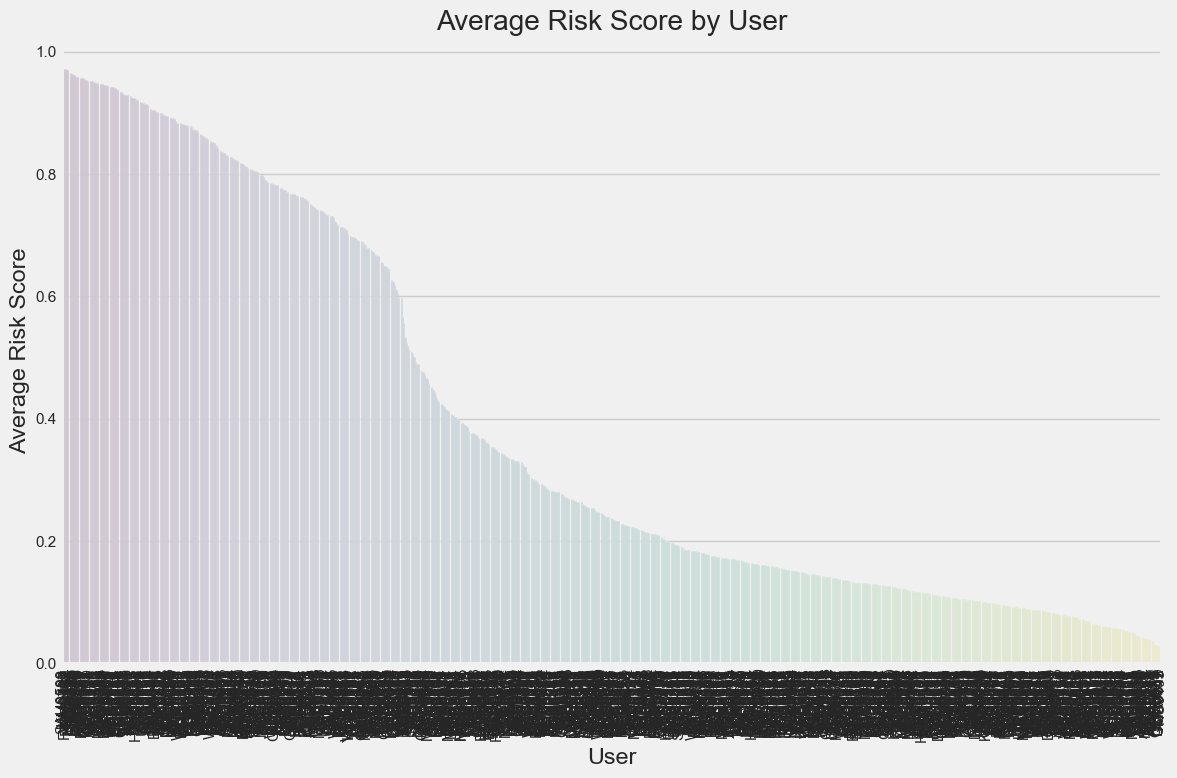

In [29]:
# Plot user risk scores
plt.figure(figsize=(12, 8))
sns.barplot(x=user_risk.index, y='mean', data=user_risk, palette='viridis')
plt.title('Average Risk Score by User')
plt.xlabel('User')
plt.ylabel('Average Risk Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [30]:
# Generate explanations for suspicious emails
def explain_suspicious_email(row, feature_importance):
    explanations = []
    
    # Check temporal patterns
    if row['is_weekend'] == 1:
        explanations.append("Email sent during weekend")
    if row['is_outside_hours'] == 1:
        explanations.append("Email sent outside regular working hours")
    
    # Check recipient patterns
    if row['external_ratio'] > 0.5:
        explanations.append(f"High ratio of external recipients ({row['external_ratio']:.2f})")
    if row['external_ratio_deviation'] > 0.3:
        explanations.append(f"Unusually high external recipient ratio (deviation: {row['external_ratio_deviation']:.2f})")
    if row['bcc_count'] > 3:
        explanations.append(f"High number of BCC recipients ({row['bcc_count']})")
    
    # Check content indicators
    if row['sensitive_word_count'] > 0:
        explanations.append(f"Contains {row['sensitive_word_count']} sensitive keywords")
    if row['attachments'] > 0:
        explanations.append(f"Contains {row['attachments']} attachments")
    if row['size'] > row['size_avg'] * 2:
        explanations.append(f"Email size ({row['size']}) is significantly larger than user average ({row['size_avg']:.0f})")
    
    # Check behavioral anomalies
    if row['unusual_pc'] == 1:
        explanations.append(f"Email sent from unusual PC ({row['pc']})")
    if row['domain_mismatch'] == 1:
        explanations.append(f"Domain mismatch in sender address ({row['from']})")
    
    return "; ".join(explanations) if explanations else "No clear explanation"

# Add explanations to high-risk emails
high_risk_threshold = 0.7
high_risk_emails = df[df['risk_score'] >= high_risk_threshold].copy()
high_risk_emails['explanation'] = high_risk_emails.apply(lambda row: explain_suspicious_email(row, feature_importance), axis=1)

print(f"Top 10 highest risk emails (risk score >= {high_risk_threshold}):")
high_risk_sample = high_risk_emails.sort_values('risk_score', ascending=False)[['id', 'date', 'user', 'risk_score', 'explanation']].head(10)
high_risk_sample

Top 10 highest risk emails (risk score >= 0.7):


,id,date,user,risk_score,explanation
3537,{P6A0-P3ZN33SK-0886TYPF},2010-01-04 10:52:42,SAH0599,0.973066,Contains 2 attachments
5845,{W3Z4-Y7IQ70XL-1829QIXB},2010-01-04 14:04:16,JKM0303,0.971088,No clear explanation
5456,{Y4U4-M0EG47PI-4627XZSA},2010-01-04 13:36:12,FWM0707,0.970918,Contains 2 attachments
7495,{Q9U7-B3ZN34NK-5009OZBA},2010-01-04 16:13:58,IJM0139,0.970905,No clear explanation
7510,{E2C7-X1IO33HR-7520COKQ},2010-01-04 16:16:28,EGD0132,0.970497,No clear explanation
6200,{O3F2-Q7KP09LG-4471ZBGV},2010-01-04 14:30:49,AMH0464,0.969174,No clear explanation
4466,{E5H0-G2WM45HR-1533PLRZ},2010-01-04 12:12:04,HSP0290,0.966900,Contains 2 attachments
7387,{T4A8-M3NN99RC-4929FIVQ},2010-01-04 16:02:36,CLS0296,0.965830,No clear explanation
8471,{L9S1-R9WK24JU-7287GEBS},2010-01-04 18:26:26,JRF0835,0.963587,Contains 2 attachments
2177,{V0X4-K6PX30BI-2683BKFF},2010-01-04 09:12:28,FRR0832,0.962680,Contains 4 attachments


## 11. Save Model and Results

In [31]:
# Save the trained model
import joblib

# Save model components
model_components = {
    'scaler': scaler,
    'pca': pca,
    'isolation_forest': isolation_forest,
    'one_class_svm': one_class_svm,
    'random_forest': best_rf,
    'feature_importance': feature_importance,
    'top_features': top_feature_names
}

joblib.dump(model_components, 'models/insider_threat_model.pkl')
print("Model saved successfully")

# Save results for further analysis
high_risk_emails.to_csv('generated_data/high_risk_emails.csv', index=False)
user_risk.to_csv('generated_data/user_risk_scores.csv')
print("Results saved successfully")

Model saved successfully
Results saved successfully


# 12. Test Single Email Prediction

In [ ]:
def predict_single_email(email_data):
   # Create a temporary DataFrame with the single email
    temp_df = pd.DataFrame([email_data])
    
    # Replicate the preprocessing steps from the original script
    
    # Convert date
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    
    # Time-based features
    temp_df['day_of_week'] = temp_df['date'].dt.dayofweek
    temp_df['hour'] = temp_df['date'].dt.hour
    temp_df['is_weekend'] = temp_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    temp_df['is_outside_hours'] = temp_df['hour'].apply(lambda x: 1 if x < 8 or x > 18 else 0)
    
    # Company domains (ensure this matches the original preprocessing)
    company_domains = ['dtaa.com', 'optonline.net', 'earthlink.net']
    
    # Handling recipients
    for col in ['to', 'cc', 'bcc']:
        temp_df[col] = temp_df[col].fillna('')
    
    # Count recipients
    temp_df['to_count'] = temp_df['to'].apply(lambda x: len(x.split(';')) if x else 0)
    temp_df['cc_count'] = temp_df['cc'].apply(lambda x: len(x.split(';')) if x else 0)
    temp_df['bcc_count'] = temp_df['bcc'].apply(lambda x: len(x.split(';')) if x else 0)
    temp_df['total_recipients'] = temp_df['to_count'] + temp_df['cc_count'] + temp_df['bcc_count']
    
    # External domain calculation
    def count_external_domains(recipients, company_domains):
        if not recipients:
            return 0
        
        count = 0
        for recipient in recipients.split(';'):
            if recipient:
                is_external = True
                for domain in company_domains:
                    if domain in recipient.lower():
                        is_external = False
                        break
                if is_external:
                    count += 1
        return count
    
    temp_df['external_to'] = temp_df['to'].apply(lambda x: count_external_domains(x, company_domains))
    temp_df['external_cc'] = temp_df['cc'].apply(lambda x: count_external_domains(x, company_domains))
    temp_df['external_bcc'] = temp_df['bcc'].apply(lambda x: count_external_domains(x, company_domains))
    temp_df['total_external'] = temp_df['external_to'] + temp_df['external_cc'] + temp_df['external_bcc']
    temp_df['external_ratio'] = temp_df['total_external'] / temp_df['total_recipients'].replace(0, 1)
    
    # Domain extraction
    def extract_domain(email):
        if not email or '@' not in email:
            return None
        return email.split('@')[-1].lower()
    
    temp_df['from_domain'] = temp_df['from'].apply(extract_domain)
    
    # Domain mismatch
    temp_df['domain_mismatch'] = temp_df.apply(
        lambda row: 1 if row['from_domain'] and row['from_domain'] not in company_domains else 0, 
        axis=1
    )
    
    # Content analysis
    sensitive_keywords = ['confidential', 'secret', 'private', 'sensitive', 'personal', 
                          'password', 'restricted', 'classified', 'proprietary', 'delete',
                          'unauthorized', 'access', 'secure', 'financial', 'salary', 'hidden',
                          'exclusive', 'undisclosed', 'destroy', 'ssn', 'social security']
    
    def count_sensitive_words(text, keywords):
        if pd.isna(text) or not text:
            return 0
        text = text.lower()
        return sum(text.count(keyword) for keyword in keywords)
    
    temp_df['content_length'] = temp_df['content'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    temp_df['word_count'] = temp_df['content'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    temp_df['sensitive_word_count'] = temp_df['content'].apply(lambda x: count_sensitive_words(str(x), sensitive_keywords))
    temp_df['size_per_word'] = temp_df['size'] / temp_df['word_count'].replace(0, 1)
    
    # User profile calculation (simulating average values)
    temp_df['total_recipients_avg'] = temp_df['total_recipients']
    temp_df['total_external_avg'] = temp_df['total_external']
    temp_df['external_ratio_avg'] = temp_df['external_ratio']
    temp_df['size_avg'] = temp_df['size']
    temp_df['content_length_avg'] = temp_df['content_length']
    
    # Deviation calculations
    temp_df['recipient_deviation'] = temp_df['total_recipients'] - temp_df['total_recipients_avg']
    temp_df['external_recipient_deviation'] = temp_df['total_external'] - temp_df['total_external_avg']
    temp_df['external_ratio_deviation'] = temp_df['external_ratio'] - temp_df['external_ratio_avg']
    temp_df['size_deviation'] = temp_df['size'] - temp_df['size_avg']
    temp_df['content_length_deviation'] = temp_df['content_length'] - temp_df['content_length_avg']
    
    # Unusual PC detection (simplified)
    temp_df['unusual_pc'] = 0
    
    # Prepare for modeling
    modeling_df = pd.get_dummies(temp_df, columns=['user', 'pc'], drop_first=True)
    
    # Ensure all required columns exist
    for col in X.columns:
        if col not in modeling_df.columns:
            modeling_df[col] = 0
    
    # Select and order columns
    modeling_df = modeling_df[X.columns]
    
    # Predict using the trained Random Forest
    risk_score = best_rf.predict_proba(modeling_df)[0][1]
    prediction = best_rf.predict(modeling_df)[0]
    
    return {
        'risk_score': risk_score,
        'is_suspicious': bool(prediction),
        'explanation': f"Risk Score: {risk_score:.4f}, {'Suspicious' if prediction else 'Normal'} Email"
    }

# Example usage
test_email = {
    'date': '2023-06-15 14:30:00',
    'user': 'john.doe',
    'pc': 'PC123',
    'to': 'external.contact@gmail.com',
    'cc': '',
    'bcc': '',
    'from': 'john.doe@company.com',
    'size': 5000,
    'attachments': 2,
    'content': 'Confidential information about our new project strategy.',
}

# Predict risk for the test email
# Predict risk for the test email
result = predict_single_email(test_email)
print(f"Risk Score: {result['risk_score']}")
print(f"Is Suspicious: {result['is_suspicious']}")
print(f"Explanation: {result['explanation']}")

Risk Score: 0.7169479163570277
Is Suspicious: True
Explanation: Risk Score: 0.7169, Suspicious Email
